株価予測をする

In [76]:
import pandas as pd

In [77]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [78]:
# Load data
df = pd.read_csv('train.csv')
df_test_base = pd.read_csv('test.csv')
df_submit = pd.read_csv('sample_submission.csv', header=None, names=['Date', 'Up'])

In [79]:
df

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


In [80]:
df_test_base

,Date,Open,High,Low,Close
0,2012-01-19,110.79,110.82,109.96,110.39
1,2012-01-20,110.45,111.10,110.36,110.73
2,2012-01-23,110.95,111.10,109.65,110.36
3,2012-01-24,110.16,110.16,108.13,108.39
4,2012-01-25,106.25,107.11,105.97,106.89
...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68
1196,2019-12-18,183.86,184.01,182.38,183.10
1197,2019-12-19,183.83,185.17,183.66,185.08
1198,2019-12-20,186.29,186.64,184.81,185.19


In [81]:
df_submit

,Date,Up
0,2012-01-26,0
1,2012-02-09,0
2,2012-02-24,0
3,2012-03-09,0
4,2012-03-23,0
...,...,...
195,2019-10-25,0
196,2019-11-08,0
197,2019-11-22,0
198,2019-12-09,0


学習データとテストデータを結合させて株価の全体トレンドを探る

<Axes: >

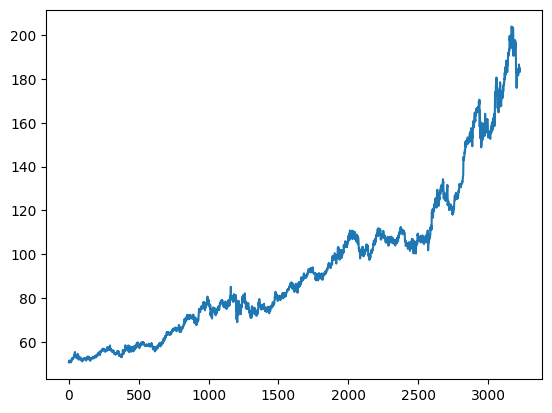

In [82]:
# インデックスが途中で0に戻らないように結合する(reset_indexをつける)ことに注意する
pd.concat([df["Close"], df_test_base["Close"]], axis=0).reset_index(drop=True).plot()

テストデータになる最近と、訓練データになる昔では株価の上がり方の傾向が異なることがわかる→学習データの学習をそのまま読み込むのでダメかも？→工夫が必要

In [83]:
pd.concat([df["Close"], df_test_base["Close"]], axis=0).reset_index(drop=True)

0        50.72
1        50.79
2        51.15
3        51.51
4        51.28
         ...  
3221    184.68
3222    183.10
3223    185.08
3224    185.19
3225    183.34
Name: Close, Length: 3226, dtype: float64

訓練データの差分系列を見ていく

In [84]:
df["Close"].diff(1)

0        NaN
1       0.07
2       0.36
3       0.36
4      -0.23
        ... 
2021   -0.26
2022    0.97
2023   -0.17
2024    0.30
2025    0.62
Name: Close, Length: 2026, dtype: float64

In [85]:
df["Close"]

0        50.72
1        50.79
2        51.15
3        51.51
4        51.28
         ...  
2021    108.86
2022    109.83
2023    109.66
2024    109.96
2025    110.58
Name: Close, Length: 2026, dtype: float64

差分を取ることによって、トレンドをある程度除去することができる  
他にも、対数を取るなど、原系列に工夫をする手段は存在する。

<Axes: >

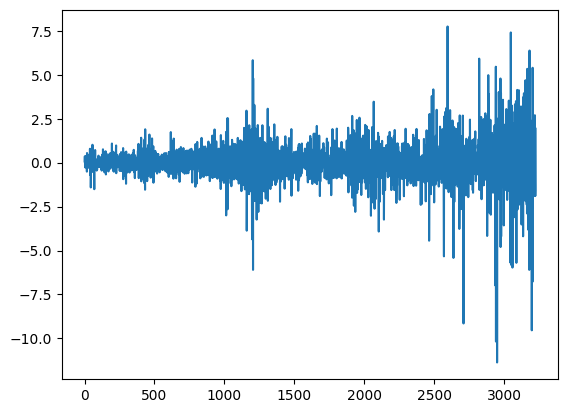

In [86]:
pd.concat([df["Close"].diff(1), df_test_base["Close"].diff(1)], axis=0).reset_index(drop=True).plot()

最近になると差分が大きくなっていることがわかる

In [87]:
pd.concat([df, df["Close"].diff(1).rename("Close_diff")], axis=1) # 訓練データの1日前との差分をカラムとして追加

,Date,Open,High,Low,Close,Up,Close_diff
0,2004-01-02,50.85,50.91,50.62,50.72,1,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,0.07
2,2004-01-06,50.87,51.26,50.86,51.15,1,0.36
3,2004-01-07,51.45,51.54,51.29,51.51,0,0.36
4,2004-01-08,51.15,51.33,51.02,51.28,0,-0.23
...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,-0.26
2022,2012-01-12,109.68,109.90,109.44,109.83,0,0.97
2023,2012-01-13,109.53,109.72,109.08,109.66,1,-0.17
2024,2012-01-17,109.99,110.47,109.57,109.96,1,0.30


どういう特徴量を作ると予測できるだろうか？  
とりあえず、今作った1日前の差分系列と、より日にちの離れたラグ系列を作成していく。今回は、5日前まで作成する。

In [88]:
df["Close"].diff(1).shift(1) # shift(1)で1行ずらす(ラグをとる)

0        NaN
1        NaN
2       0.07
3       0.36
4       0.36
        ... 
2021   -0.43
2022   -0.26
2023    0.97
2024   -0.17
2025    0.30
Name: Close, Length: 2026, dtype: float64

In [89]:
pd.concat([df, df["Close"].diff(1).rename("Close_diff"), df["Close"].diff(1).shift(1).rename("Close_diff_1daylag")], axis=1)

,Date,Open,High,Low,Close,Up,Close_diff,Close_diff_1daylag
0,2004-01-02,50.85,50.91,50.62,50.72,1,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,50.79,1,0.07,NaN
2,2004-01-06,50.87,51.26,50.86,51.15,1,0.36,0.07
3,2004-01-07,51.45,51.54,51.29,51.51,0,0.36,0.36
4,2004-01-08,51.15,51.33,51.02,51.28,0,-0.23,0.36
...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1,-0.26,-0.43
2022,2012-01-12,109.68,109.90,109.44,109.83,0,0.97,-0.26
2023,2012-01-13,109.53,109.72,109.08,109.66,1,-0.17,0.97
2024,2012-01-17,109.99,110.47,109.57,109.96,1,0.30,-0.17


Next motivation : 特徴量の作成を関数により行いたい！

In [90]:
# data_preprocess関数は、データフレームとカラム名を受け取り、指定されたカラムの差分を5日分のラグまで計算し、それら新しいカラムを追加して元のカラムを削除する関数
def data_preprocess(df,col):
    df = pd.concat([df, df[col].diff(1).rename(f"{col}_diff"), df[col].diff(1).shift(1).rename(f"{col}_diff_1daylag"), df[col].diff(1).shift(2).rename(f"{col}_diff_2daylag"), df[col].diff(1).shift(3).rename(f"{col}_diff_3daylag"), df[col].diff(1).shift(4).rename(f"{col}_diff_4daylag"), df[col].diff(1).shift(5).rename(f"{col}_diff_5daylag")], axis=1)
    df = df.drop(col, axis=1) # 元のカラムは削除
    return df

In [91]:
df

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


In [92]:
df_tmp = data_preprocess(df, "Close")
df_tmp

,Date,Open,High,Low,Up,Close_diff,Close_diff_1daylag,Close_diff_2daylag,Close_diff_3daylag,Close_diff_4daylag,Close_diff_5daylag
0,2004-01-02,50.85,50.91,50.62,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-01-05,50.75,50.84,50.61,1,0.07,NaN,NaN,NaN,NaN,NaN
2,2004-01-06,50.87,51.26,50.86,1,0.36,0.07,NaN,NaN,NaN,NaN
3,2004-01-07,51.45,51.54,51.29,0,0.36,0.36,0.07,NaN,NaN,NaN
4,2004-01-08,51.15,51.33,51.02,0,-0.23,0.36,0.36,0.07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,1,-0.26,-0.43,-0.31,0.60,2.07,-1.21
2022,2012-01-12,109.68,109.90,109.44,0,0.97,-0.26,-0.43,-0.31,0.60,2.07
2023,2012-01-13,109.53,109.72,109.08,1,-0.17,0.97,-0.26,-0.43,-0.31,0.60
2024,2012-01-17,109.99,110.47,109.57,1,0.30,-0.17,0.97,-0.26,-0.43,-0.31


In [94]:
## 学習データへの特徴量追加
df = df.drop(["Date"], axis=1)
df = data_preprocess(df, "Open") # Openの差分を追加
df = data_preprocess(df, "High") # Highの差分を追加
df = data_preprocess(df, "Low") # Lowの差分を追加
df = data_preprocess(df, "Close") # Closeの差分を追加

# テストデータへの特徴量追加
df_test = df_test_base.drop(["Date"], axis=1)
df_test = data_preprocess(df_test, "Open") # Openの差分を追加
df_test = data_preprocess(df_test, "High") # Highの差分を追加
df_test = data_preprocess(df_test, "Low") # Lowの差分を追加
df_test = data_preprocess(df_test, "Close") # Closeの差分を追加

XGBoostとLightGBMについて  
勾配ブースティング手法の一つ
- XGBoostの基本
 - 決定木とアンサンブル学習
 - バギング、ブースティング、スタッキングの三つのアンサンブル学習のうち、二つ目を使う。
- XGBoostの仲間
 - LightGBM
  - XGBoostの発展版。軽量なので計算負荷が軽い
  - 特徴量をヒストグラム化する
  - 決定木の使い方が違う
  - 過学習の可能性が高くなる
  - XGBoostよりも計算や学習は速いが、必ずしも精度が高くなるとは限らない。
 - CatBoost
  - カテゴリ変数に強いという特徴がある
  - メジャーではないが、他の二つよりも高い精度を弾き出すことがある
- XGBoostを使う場面
 - あらゆる場面で使える
 - ex)チャーン分析：解約顧客の予測
 - 特徴量重要度の可視化が可能
 - 標準化をしなくても良いと言う特徴もある


In [95]:
## モデル構築
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=0) # 訓練データと検証データに分割

col = "Up"
train_y = df_train[col] # 目的変数の抜き出し
train_x = df_train.drop(col, axis=1)
valid_y = df_valid[col] # 目的変数の抜き出し
valid_x = df_valid.drop(col, axis=1)

trains = lgb.Dataset(train_x, train_y) # 学習データをlgb.Dataset形式に変換
valids = lgb.Dataset(valid_x, valid_y) # 検証データをlgb.Dataset形式に変換

# パラメータ設定
params = {
    'objective': 'binary', # 目的関数。ここで二値分類タスクであることを示している
    'metrics': 'binary_logloss', # 評価指標
}

# モデルの学習
model = lgb.train(params, trains, valid_sets=valids, num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10)])

[LightGBM] [Info] Number of positive: 828, number of negative: 792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511111 -> initscore=0.044452
[LightGBM] [Info] Start training from score 0.044452
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.665725


次にテストデータの予測をする

In [96]:
model_predict = model.predict(df_test) # 学習したモデルを使い、テストデータに対するUp=1の確率を予測
model_predict

array([0.72170235, 0.62964715, 0.40418413, ..., 0.69360356, 0.35328578,
       0.66137908], shape=(1200,))

In [104]:
threshold = 0.5

predict_list = []
for i in model_predict:
    if i >= threshold:
        Up = 1
    else:
        Up = 0
    predict_list.append(Up)
    
predict_list # 1200日分の予測結果

[1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,


In [106]:
df_predict = pd.concat([df_test_base, pd.Series(predict_list).rename("Up")], axis=1) # 予測結果を元のデータフレームに結合
df_predict

,Date,Open,High,Low,Close,Up
0,2012-01-19,110.79,110.82,109.96,110.39,1
1,2012-01-20,110.45,111.10,110.36,110.73,1
2,2012-01-23,110.95,111.10,109.65,110.36,0
3,2012-01-24,110.16,110.16,108.13,108.39,0
4,2012-01-25,106.25,107.11,105.97,106.89,1
...,...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68,0
1196,2019-12-18,183.86,184.01,182.38,183.10,1
1197,2019-12-19,183.83,185.17,183.66,185.08,1
1198,2019-12-20,186.29,186.64,184.81,185.19,0


提出用データの作成

In [107]:
df_submit # 提出用ファイルの確認

,Date,Up
0,2012-01-26,0
1,2012-02-09,0
2,2012-02-24,0
3,2012-03-09,0
4,2012-03-23,0
...,...,...
195,2019-10-25,0
196,2019-11-08,0
197,2019-11-22,0
198,2019-12-09,0


In [114]:
# df_submitにある日付のものだけを抽出
df_submit = pd.merge(df_submit[["Date"]], df_predict[["Date", "Up"]], how="left", on="Date") # 左にあるdf_submitのDateを基準に結合
df_submit

,Date,Up
0,2012-01-26,0
1,2012-02-09,1
2,2012-02-24,0
3,2012-03-09,0
4,2012-03-23,1
...,...,...
195,2019-10-25,1
196,2019-11-08,1
197,2019-11-22,1
198,2019-12-09,0


In [115]:
df_submit.to_csv("submit.csv", header=False, index=False) # 提出要件に合わせて、ヘッダーなし、インデックスなしで保存